In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "amitkumar136"
os.environ['KAGGLE_KEY'] = "9a8a525535378b68952c46ec765917d8"

In [2]:
!kaggle competitions download -c paddy-disease-classification

 98%|██████████████████████████████████████▏| 1.00G/1.02G [00:03<00:00, 293MB/s]
100%|███████████████████████████████████████| 1.02G/1.02G [00:04<00:00, 271MB/s]


In [3]:
from zipfile import ZipFile

In [4]:
!unzip -qq paddy-disease-classification.zip

In [5]:
# filepath = '/content/drive/MyDrive/paddy-disease-classification.zip'
# with ZipFile(filepath, 'r') as zip:
#   zip.extractall()
#   print('Extraction Completed')

In [6]:
import pandas as pd
df = pd.read_csv('./train.csv')
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [7]:
df.shape

(10407, 4)

In [8]:
df = df[['image_id', 'label']]
df.head()

,image_id,label
0,100330.jpg,bacterial_leaf_blight
1,100365.jpg,bacterial_leaf_blight
2,100382.jpg,bacterial_leaf_blight
3,100632.jpg,bacterial_leaf_blight
4,101918.jpg,bacterial_leaf_blight


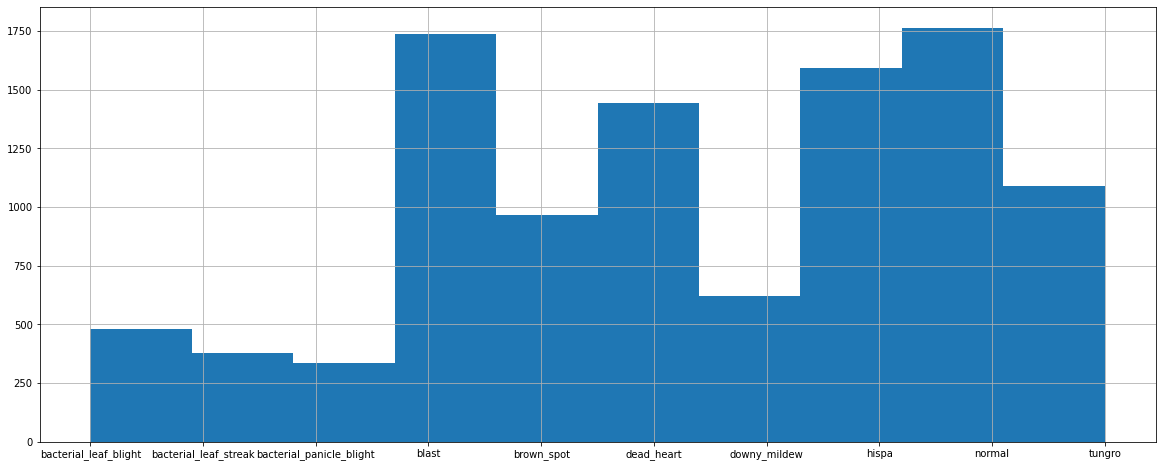

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
df['label'].hist()
plt.show()


In [10]:
classes = os.listdir('./train_images')
classes

['brown_spot',
 'bacterial_leaf_blight',
 'tungro',
 'bacterial_leaf_streak',
 'normal',
 'dead_heart',
 'bacterial_panicle_blight',
 'downy_mildew',
 'hispa',
 'blast']

### Image preprocessor

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
import cv2
def blur(img):
    return cv2.blur(img, (5, 5))

In [13]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    preprocessing_function=blur
)

In [14]:
BATCH = 64
IMAGE_SIZE=(224, 224)
train_ds = idg.flow_from_directory(
    './train_images',
    classes=classes,
    batch_size=BATCH,
    target_size=IMAGE_SIZE,
    class_mode='binary', # 0 1 2 3 4 5 6 7 8 9
    subset="training"
)
val_ds = idg.flow_from_directory(
    './train_images',
    classes=classes,
    batch_size=BATCH,
    target_size=IMAGE_SIZE,
    class_mode='binary', # 0 1 2 3 4 5 6 7 8 9
    subset="validation"
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense

In [2]:
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.20),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3,3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.15),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.1),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

In [3]:
from tensorflow.keras.optimizers import Adam
op = Adam(learning_rate = 0.01, decay = 0.0001)
model.compile(optimizer=op, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.build((None, 224, 224, 3))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
cb = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=2),
    EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)
]

In [21]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 200,
                    callbacks = cb,
                    verbose = 1)


2022-09-05 04:39:35.303069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-09-05 04:39:37.878451: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


131/131 [==============================] - 174s 1s/step - loss: 15.3765 - accuracy: 0.1640 - val_loss: 2.1615 - val_accuracy: 0.1671

Epoch 00001: val_accuracy improved from -inf to 0.16707, saving model to best_model.h5
Epoch 2/200
131/131 [==============================] - 166s 1s/step - loss: 2.1637 - accuracy: 0.1701 - val_loss: 2.1643 - val_accuracy: 0.1671

Epoch 00002: val_accuracy did not improve from 0.16707
Epoch 3/200
131/131 [==============================] - 165s 1s/step - loss: 2.1630 - accuracy: 0.1676 - val_loss: 2.1605 - val_accuracy: 0.1671

Epoch 00003: val_accuracy did not improve from 0.16707
Epoch 4/200
131/131 [==============================] - 165s 1s/step - loss: 2.1625 - accuracy: 0.1634 - val_loss: 2.1595 - val_accuracy: 0.1671

Epoch 00004: val_accuracy did not improve from 0.16707
Epoch 5/200
131/131 [==============================] - 165s 1s/step - loss: 2.1620 - accuracy: 0.1705 - val_loss: 2.1599 - val_accuracy: 0.1671

Epoch 00005: val_accuracy did not 

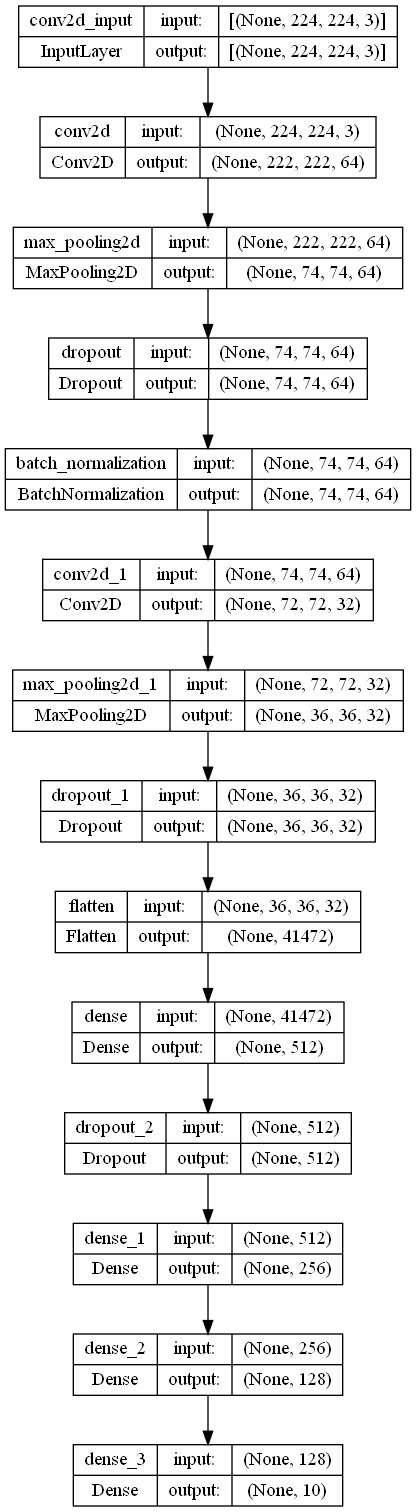

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [1]:
from keras.models import load_model
model = load_model("best_model.h5")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

#### Train Image Testing

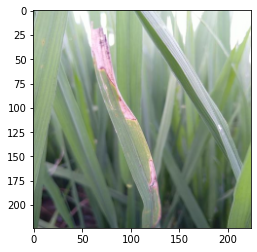

In [4]:
test_img = plt.imread('./test_image.jpg')
test_img = resize(test_img, (224, 224, 3))
plt.imshow(test_img)

In [5]:
pred = model.predict(np.array([test_img]))
pred

1/1 [==============================] - 1s 518ms/step


array([[0.10369074, 0.04805747, 0.10884728, 0.03609948, 0.16665581,
        0.13013647, 0.03646965, 0.06287463, 0.14405893, 0.16310954]],
      dtype=float32)

In [6]:
classes = ['tungro','hispa','downy_mildew','bacterial_leaf_streak','bacterial_leaf_blight','brown_spot','blast','normal','dead_heart','bacterial_panicle_blight']

for cls, prediction in zip(classes, pred[0]):
    print(f"{cls}: {prediction*100:.2f}%")

tungro: 10.37%
hispa: 4.81%
downy_mildew: 10.88%
bacterial_leaf_streak: 3.61%
bacterial_leaf_blight: 16.67%
brown_spot: 13.01%
blast: 3.65%
normal: 6.29%
dead_heart: 14.41%
bacterial_panicle_blight: 16.31%


#### Test Image Testing

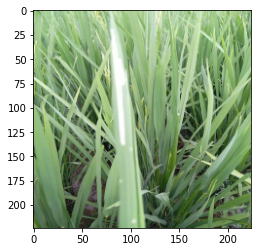

In [7]:
test_img = plt.imread('./200101.jpg')
test_img = resize(test_img, (224, 224, 3))
plt.imshow(test_img)

In [8]:
pred = model.predict(np.array([test_img]))
pred

1/1 [==============================] - 0s 50ms/step


array([[0.10369074, 0.04805747, 0.10884728, 0.03609948, 0.16665581,
        0.13013647, 0.03646965, 0.06287463, 0.14405893, 0.16310954]],
      dtype=float32)

In [9]:
classes = ['tungro','hispa','downy_mildew','bacterial_leaf_streak','bacterial_leaf_blight','brown_spot','blast','normal','dead_heart','bacterial_panicle_blight']

for cls, prediction in zip(classes, pred[0]):
    print(f"{cls}: {prediction*100:.2f}%")

tungro: 10.37%
hispa: 4.81%
downy_mildew: 10.88%
bacterial_leaf_streak: 3.61%
bacterial_leaf_blight: 16.67%
brown_spot: 13.01%
blast: 3.65%
normal: 6.29%
dead_heart: 14.41%
bacterial_panicle_blight: 16.31%


In [11]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)
test = idg.flow_from_directory(
    directory='./train_images/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False,
    seed=42
)

NameError: name 'ImageDataGenerator' is not defined

In [10]:
model.evaluate(test, batch_size = 1, verbose=1)

NameError: name 'test' is not defined